In [1]:
import pandas as pd 

In [43]:
import os
import pandas as pd

def collect_scores(base_dir, input_word, score_field, pif_index_col='Unnamed: 0'):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().startswith(input_word) and file.lower().endswith(".csv"):
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(os.path.dirname(file_path))

                try:
                    # Read the file
                    df = pd.read_csv(file_path)

                    if input_word.lower() == 'pif':
                        # For PIF files, use 'Unnamed: 0' as the original index
                        if pif_index_col in df.columns and score_field in df.columns:
                            temp_df = df[[score_field]].copy()
                            temp_df['original_index'] = df[pif_index_col]
                            temp_df['file_name'] = file
                            temp_df['folder_name'] = folder_name
                            all_data.append(temp_df)
                    elif input_word.lower() == 'suda':
                        # For SUDA files, use the DataFrame's default index
                        if score_field in df.columns:
                            temp_df = df[[score_field]].copy()
                            temp_df['original_index'] = df.index
                            temp_df['file_name'] = file
                            temp_df['folder_name'] = folder_name
                            all_data.append(temp_df)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

    if all_data:
        result_df = pd.concat(all_data, ignore_index=True)
        return result_df
    else:
        return pd.DataFrame(columns=[score_field, 'original_index', 'file_name', 'folder_name'])

# Specify the base directory
base_directory = os.getcwd()

# Collect scores for 'suda' datasets
result_suda = collect_scores(base_directory, 'suda', 'dis-score')

# Collect scores for 'pif' datasets
result_pif = collect_scores(base_directory, 'pif', 'RIG')
result_pif = result_pif.sort_values(by=['file_name', 'original_index'], ascending=[True, True])


In [55]:
result_suda

,dis-score,original_index,file_name,folder_name
0,0.9709,0,SUDA_ds003097.csv,data_ds003097
1,0.9789,1,SUDA_ds003097.csv,data_ds003097
2,0.9821,2,SUDA_ds003097.csv,data_ds003097
3,0.9134,3,SUDA_ds003097.csv,data_ds003097
4,0.0000,4,SUDA_ds003097.csv,data_ds003097
...,...,...,...,...
3647,1.0000,5,suda_ds000224.csv,data_ds000224
3648,1.0000,6,suda_ds000224.csv,data_ds000224
3649,1.0000,7,suda_ds000224.csv,data_ds000224
3650,1.0000,8,suda_ds000224.csv,data_ds000224


Merged DataFrame:
Global Spearman Correlation: 0.7795, P-value: 0.0000


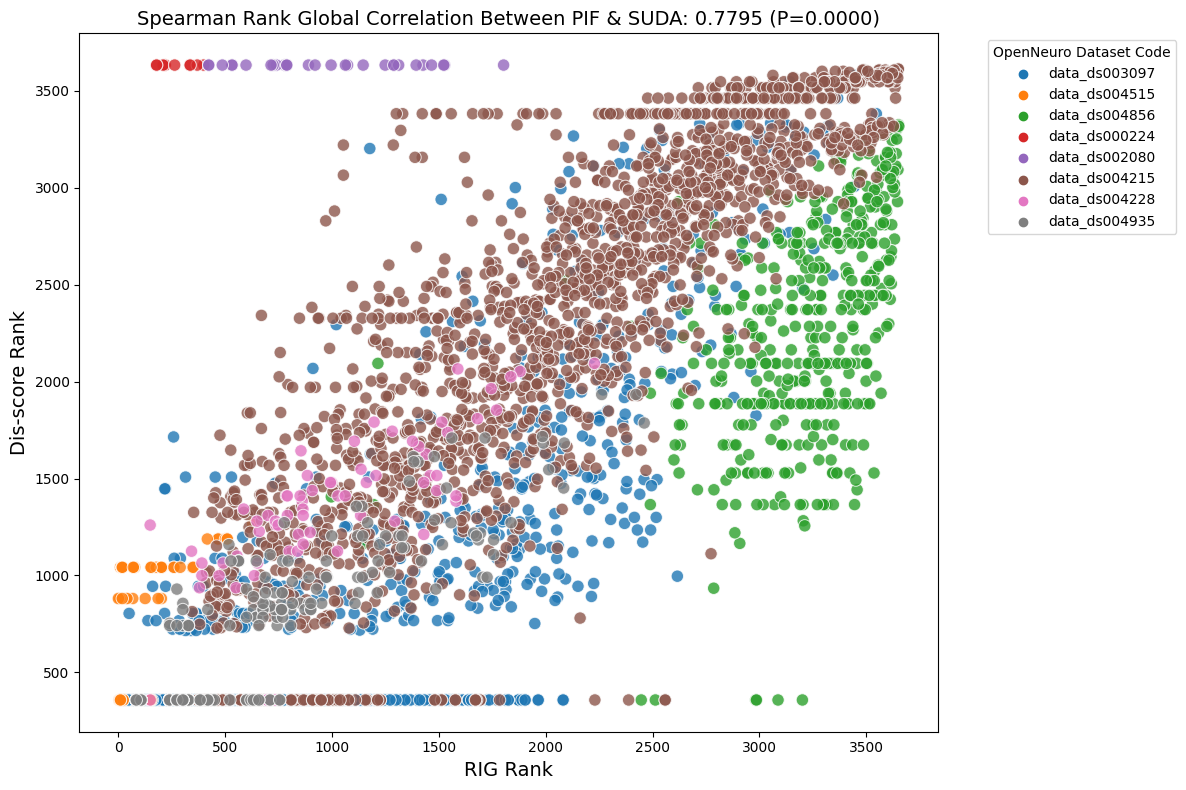

In [72]:
# Merge the datasets on `original_index` and `file_name`
merged = pd.merge(result_pif, result_suda, on=['original_index', 'folder_name'], suffixes=('_pif', '_suda'))

# Check if the merge worked
if merged.empty:
    print("The merged DataFrame is empty. Check file names and original index alignment.")
else:
    print("Merged DataFrame:")


    # Compute the ranks for `RIG` and `dis-score`
    merged['RIG_rank'] = merged['RIG'].rank()
    merged['dis_score_rank'] = merged['dis-score'].rank()

    # Compute Spearman rank correlation globally
    spearman_corr, p_value = spearmanr(merged['RIG'], merged['dis-score'])

    print(f"Global Spearman Correlation: {spearman_corr:.4f}, P-value: {p_value:.4f}")

    # Plot the rank values
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=merged, 
        x='RIG_rank',        # X-axis: rank of RIG
        y='dis_score_rank',  # Y-axis: rank of dis-score
        hue='folder_name',   # Color points by folder_name
        palette='tab10',
        s=80,
        alpha=0.8# Adjust point size
    )

    # Add labels and title
    plt.title(f"Spearman Rank Global Correlation Between PIF & SUDA: {spearman_corr:.4f} (P={p_value:.4f})", fontsize=14)
    plt.xlabel('RIG Rank', fontsize=14)
    plt.ylabel('Dis-score Rank', fontsize=14)
    plt.legend(title='OpenNeuro Dataset Code', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save and show the plot
    plt.savefig('spearman_rank_correlation_plot.png', dpi=300)
    plt.show()

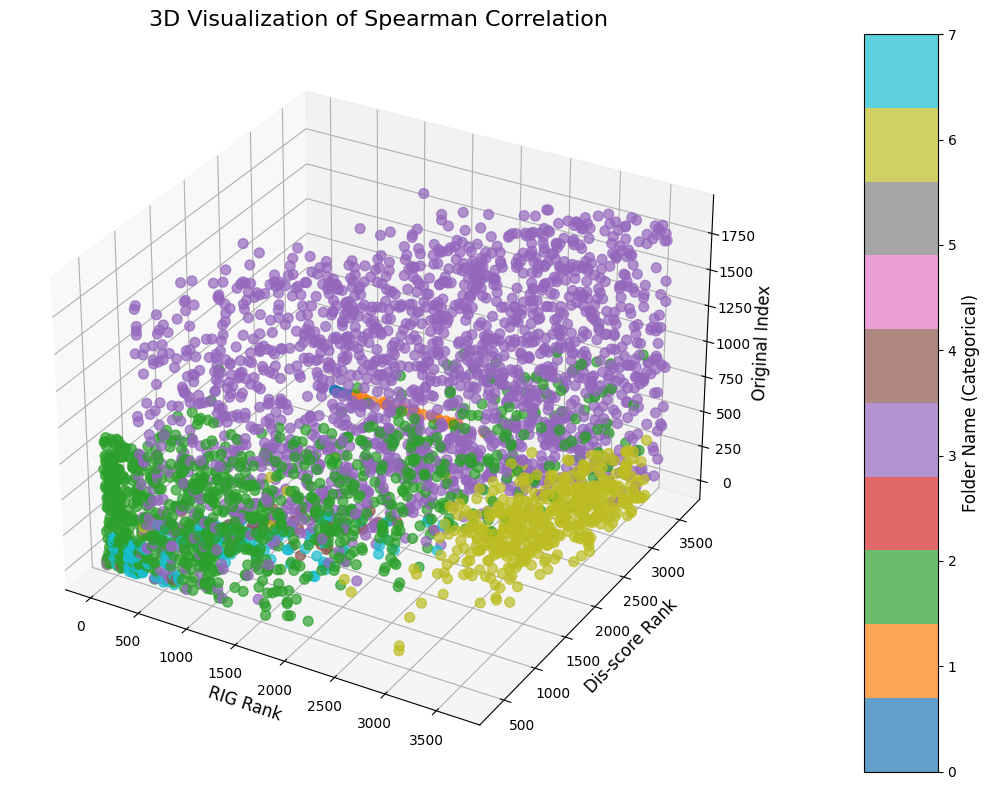

In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plots

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D Scatter plot
scatter = ax.scatter(
    merged['RIG_rank'],       # X-axis: RIG Rank
    merged['dis_score_rank'], # Y-axis: Dis-score Rank
    merged['original_index'], # Z-axis: Original Index
    c=merged['folder_name'].astype('category').cat.codes,  # Color by folder_name
    cmap='tab10',             # Use a distinctive colormap
    s=50,                     # Size of points
    alpha=0.7                 # Transparency of points
)

# Label the axes
ax.set_title(f"3D Visualization of Spearman Correlation", fontsize=16)
ax.set_xlabel('RIG Rank', fontsize=12)
ax.set_ylabel('Dis-score Rank', fontsize=12)
ax.set_zlabel('Original Index', fontsize=12)

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1, aspect=10)
cbar.set_label('Folder Name (Categorical)', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
